# About
For loading existing policies and visualizing rollout

In [1]:
import jax
from jax import numpy as jp
from IPython.display import HTML

import brax
from brax import envs
from brax.io import model
from brax.io import html
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.acme import running_statistics
import matplotlib.pyplot as plt

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [4]:
from uni_bracketbot_env import Uni_Balance_BracketBot

envs.register_environment("Balance_BracketBot", Uni_Balance_BracketBot)
env = envs.get_environment("Balance_BracketBot")

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

ROLLOUT_LENGTH = 1000

/Users/magi/Code/robots/.venv/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [5]:
params = model.load_params("policies/bracket_policy_balance_uni")

ppo_network = ppo_networks.make_ppo_networks(
    observation_size=env.observation_size,
    action_size=env.action_size,
    preprocess_observations_fn=running_statistics.normalize
)

make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
inference_fn = make_inference_fn(params)

In [ ]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

rollout = [state.pipeline_state]
pitch = [state.metrics['pitch']]
roll = [state.metrics['roll']]
yaw = [state.metrics['yaw']]

for i in range(ROLLOUT_LENGTH):
    act_rng, rng = jax.random.split(rng)
    
    action, _ = inference_fn(state.obs, act_rng)
    state = jit_step(state, action)
    done = state.done

    if done:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)
    pitch.append(state.metrics['pitch'])
    roll.append(state.metrics['roll'])
    yaw.append(state.metrics['yaw'])

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

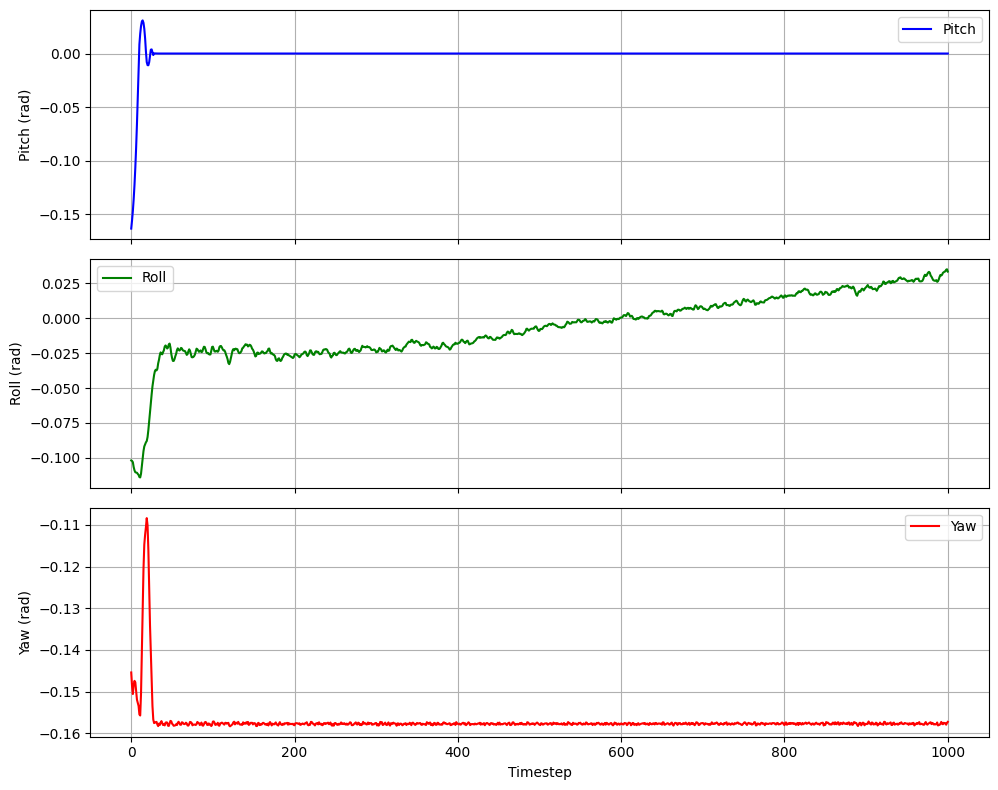

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(pitch, label='Pitch', color='blue')
axes[0].set_ylabel('Pitch (rad)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(roll, label='Roll', color='green')
axes[1].set_ylabel('Roll (rad)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(yaw, label='Yaw', color='red')
axes[2].set_ylabel('Yaw (rad)')
axes[2].set_xlabel('Timestep')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()